In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [86]:
VERBOSE = 0
N_JOBS = -1

# Evaluation

Article Source: A Comparative Evaluation of Unsupervised Anomaly Detection Algorithms for Multivariate Data 
Goldstein M, Uchida S (2016) A Comparative Evaluation of Unsupervised Anomaly Detection Algorithms for Multivariate Data. PLOS ONE 11(4): e0152173. https://doi.org/10.1371/journal.pone.0152173

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OPQMVF

I'm going to test the following dataset:
1. Pen-Global
1. Pen-Local
1. Speech
1. Aloi

On the following metrics: ROC-AUC

## Pen-Global Dataset

Paper version: https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/OPQMVF/KQYDN9&version=1.0

Original UCI: https://archive.ics.uci.edu/ml/datasets/Pen-Based%20Recognition%20of%20Handwritten%20Digits

In [87]:
def plot_datapoint(datapoint):
    xs = []
    ys = []

    for i, v in enumerate(datapoint):
        if i % 2 == 0:
            xs.append(v)
        else:
            ys.append(v)

    plt.plot(xs, ys)
    plt.show()

In [88]:
input_names = []

for i in range(8):
    input_names.append(f'x{i}')
    input_names.append(f'y{i}')

data = pd.read_csv('/Users/maxfrax/Downloads/pen-global-unsupervised-ad.csv', names=input_names+['outlier'])
data = data.sample(frac=1)

In [89]:
data

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,outlier
464,100.0,83.0,29.0,100.0,27.0,65.0,86.0,32.0,59.0,0.0,0.0,21.0,45.0,58.0,99.0,89.0,n
130,64.0,100.0,34.0,73.0,100.0,39.0,94.0,3.0,0.0,0.0,38.0,38.0,90.0,74.0,76.0,95.0,n
159,85.0,69.0,47.0,100.0,0.0,75.0,44.0,38.0,72.0,0.0,16.0,16.0,57.0,55.0,100.0,87.0,n
102,2.0,85.0,31.0,100.0,76.0,74.0,62.0,37.0,47.0,0.0,100.0,8.0,68.0,30.0,0.0,41.0,o
568,83.0,63.0,77.0,55.0,100.0,15.0,35.0,0.0,23.0,38.0,70.0,73.0,63.0,100.0,0.0,78.0,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,66.0,90.0,6.0,55.0,100.0,73.0,45.0,100.0,33.0,46.0,0.0,0.0,89.0,11.0,13.0,23.0,n
279,67.0,66.0,56.0,100.0,10.0,74.0,59.0,38.0,70.0,0.0,0.0,15.0,29.0,54.0,100.0,82.0,n
615,8.0,44.0,30.0,84.0,100.0,100.0,97.0,59.0,66.0,19.0,67.0,0.0,61.0,38.0,0.0,69.0,n
322,35.0,100.0,0.0,80.0,45.0,41.0,96.0,3.0,44.0,0.0,34.0,38.0,100.0,67.0,78.0,93.0,n


In [90]:
X = data[input_names]
y = data['outlier'] == 'o'

y = [-1 if v else 1 for v in y]

### Normalization

In the paper the declare they scale all their datasets with MinMax (Normalization section)

In [91]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X, columns=input_names)

Let's plot the first number to show we understood the dataset correctly. As we can see the plot shows the number 8, which is expected since the normal class is just the number 8.

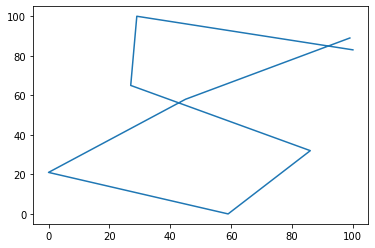

464    n
Name: outlier, dtype: object

In [92]:
plot_datapoint(data[input_names][0:1].values[0])
data[0:1]['outlier']

Plot with scaling applied:

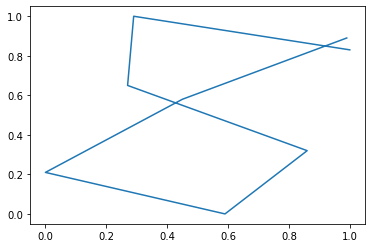

464    n
Name: outlier, dtype: object

In [93]:
plot_datapoint(X[0:1].values[0])
data[0:1]['outlier']

### Replicating: One Class SVM

I'm going to use sklearn implementation https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html since both the paper and sklearn refer to:

Estimating the support of a high-dimensional distribution Schölkopf, Bernhard, et al. Neural computation 13.7 (2001): 1443-1471.

In the paper they use OneClassSVM in an unsupervised setting.

> In the unsupervised anomaly detection scenario, the one-class SVM is trained using the dataset and afterwards, each instance in the dataset is scored by a normalized distance to the determined decision boundary [40]. The parameter ν needs to be set to a value lager than zero such that the contained anomalies are correctly handled by a soft-margin

The hyper parameters tested are 0.2 < v < 0.8 and automatic tuning for the Gaussian kernel.
By automatic tuning I guess they talk about trial and error. In fact they declare it as a computationally hard task.

In [94]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import uniform
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

In [95]:
def svm_experiment(classifier, distributions, metric: str):
    print(f'One Class Experiment: {metric}')

    # Gamma is a free parameter. It ranges from 0 to infinity
    # Predefined split to train on the whole dataset and test on the whole dataset
    test_fold = [0 if v < len(X) else 1 for v in range(len(X) * 2)]

    search = RandomizedSearchCV(classifier, distributions, cv=PredefinedSplit(test_fold=test_fold), refit=True, n_iter=100, scoring='average_precision', n_jobs=N_JOBS, error_score='raise', verbose=VERBOSE)

    res = search.fit(pd.concat([X,X]).to_numpy(), y+y)

    clf = res.best_estimator_

    print(res.best_index_)
    print(res.best_score_)
    print(res.best_params_)


    y_pred = clf.predict(X.to_numpy())

    conf_mat = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(conf_mat).plot()
    plt.show()

    display(conf_mat)

    RocCurveDisplay.from_predictions(y, clf.score_samples(X.to_numpy()))

    plt.show()

    PrecisionRecallDisplay.from_predictions(y, clf.score_samples(X.to_numpy()))

    plt.show()

    cv_results = pd.DataFrame(res.cv_results_)
    cv_results.sort_values('rank_test_score')

    print(f"Average Score: {np.average(cv_results['mean_test_score'])}")
    print(f"STD Score: {np.std(cv_results['mean_test_score'])}")

One Class Experiment: roc_auc
72
0.9983188152179511
{'gamma': 2.5146591317980347, 'nu': 0.7747940226086794}


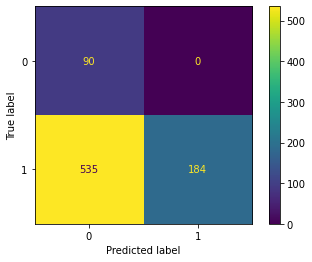

array([[ 90,   0],
       [535, 184]])

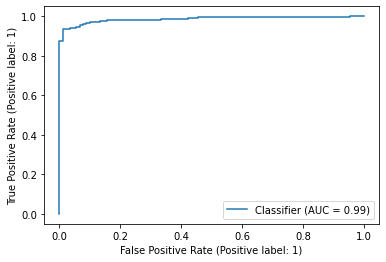

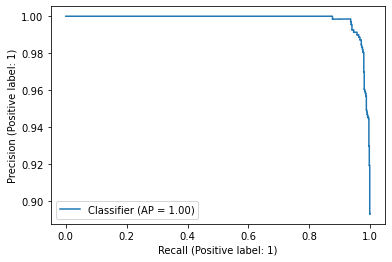

Average Score: 0.989762901333693
STD Score: 0.009500334988043554
One Class Experiment: average_precision
77
0.9983364076778265
{'gamma': 2.767882989533467, 'nu': 0.8229440398981096}


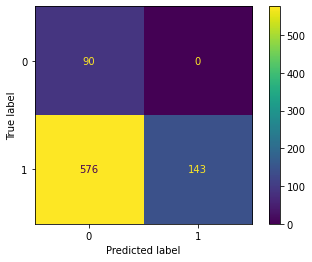

array([[ 90,   0],
       [576, 143]])

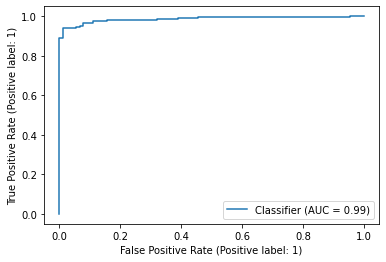

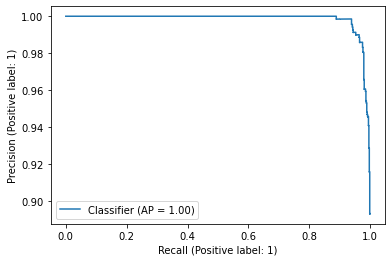

Average Score: 0.9896715121943571
STD Score: 0.009302124793336523


In [96]:
classifier = OneClassSVM(kernel='rbf')
distributions = dict(nu=uniform(loc=0.2, scale=0.8), gamma=uniform(loc=0, scale=3))

svm_experiment(classifier, distributions, 'roc_auc')
svm_experiment(classifier, distributions, 'average_precision')

### My Algorithm: BSVClassifier

In [97]:
import sys
import os

PATH_FLOD = "/Users/maxfrax/Desktop/FederatedLearningOutlierDetection"

sys.path.append(os.path.abspath(PATH_FLOD))

from flod.classifiers.bsvclassifier import BSVClassifier

One Class Experiment: roc_auc
2
1.0
{'c': 0.6822296334129778, 'q': 2.118424868813288}


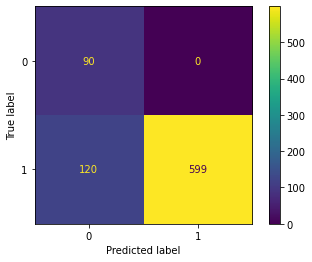

array([[ 90,   0],
       [120, 599]])

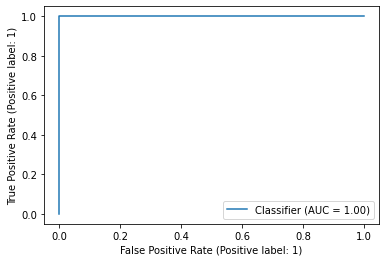

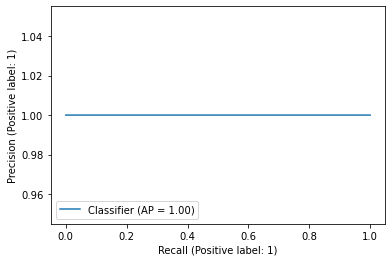

Average Score: 0.9968866708113044
STD Score: 0.008147206408453027
One Class Experiment: average_precision
0
1.0
{'c': 0.52451521540439, 'q': 2.241013555313346}


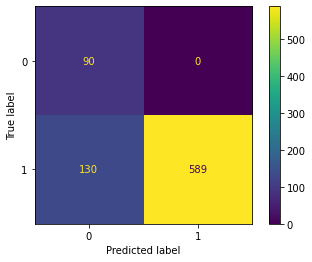

array([[ 90,   0],
       [130, 589]])

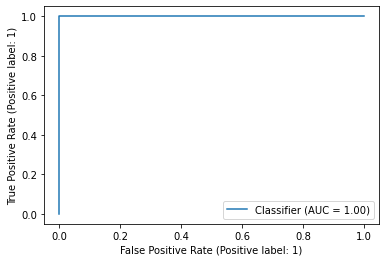

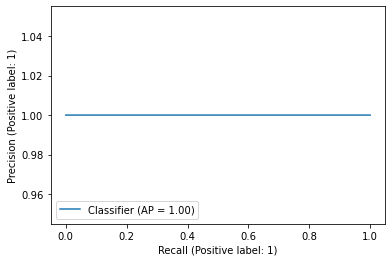

Average Score: 0.9978160846764527
STD Score: 0.006874232576865097


In [98]:
classifier = BSVClassifier(normal_class_label=1, outlier_class_label=-1)
distributions = {'c':uniform(loc=0.2, scale=0.8),'q':uniform(loc=0, scale=3)}

svm_experiment(classifier, distributions, 'roc_auc')
svm_experiment(classifier, distributions, 'average_precision')

### Federated Learning: BSVClassifier

The whole work is inspired by https://arxiv.org/pdf/1602.05629.pdf paper.

Since we are working in an unsupervised setting, our metric is not Accuracy but Roc-Auc.

We will not use E, number of iterations per client update, since we are doing exact calculation and not gradient descent.
Same thing with the parameter B

In [99]:
import sys
import os

PATH_FLOD = "/Users/maxfrax/Desktop/FederatedLearningOutlierDetection"

sys.path.append(os.path.abspath(PATH_FLOD))

from flod.classifiers.federatedbsvclassifier import FederatedBSVClassifier

#### IID

We have about **809 samples**. 
Let's sort them and distribute them among **10 clients**.

There are 9 points that will be randomly left over.

In [102]:
# The data has already been shuffled at the beginning of the file
total_clients = 10

data_per_client = int(len(X)/total_clients)

X = X[0:data_per_client*total_clients]
y = y[0:data_per_client*total_clients]

client_assignment = []

# Split the data among the clients in a balanced way
for i in range(total_clients):
    client_assignment.extend([i]*data_per_client)

print(f'len Client assignment {len(client_assignment)} == len X {len(X)}')

len Client assignment 800 == len X 800


In [103]:
# Inputs
# C: 0 aka 1 client, .1, .2, .5, 1 aka total_clients
# B: 'infinite' aka data_per_client, 1% of data_per_client

parameters = {
'client_fraction': [.1, .5,  1],
'max_rounds': [1, 3, 5],
'B': [1, 5, 10]
}

test_fold = [0 if v < len(X) else 1 for v in range(len(X) * 2)]

search = GridSearchCV(FederatedBSVClassifier(normal_class_label=1, outlier_class_label=-1, total_clients=total_clients), parameters, cv=PredefinedSplit(test_fold=test_fold), refit=True, scoring='average_precision', error_score='raise', verbose=VERBOSE)
res = search.fit(pd.concat([X,X]).to_numpy(), np.array(y+y), client_assignment=client_assignment+client_assignment)

clf = res.best_estimator_

print(res.best_index_)
print(res.best_score_)
print(res.best_params_)


y_pred = clf.predict(X.to_numpy())

Round 0 of 1
Selected clients [3]
Round 0 of 1
Selected clients [3]
Round 0 of 3
Selected clients [1]
Round 1 of 3
Selected clients [4]
Round 2 of 3
Selected clients [1]
Round 0 of 3
Selected clients [9]
Round 1 of 3
Selected clients [3]
Round 2 of 3
Selected clients [0]
Round 0 of 5
Selected clients [8]
Round 1 of 5
Selected clients [6]
Round 2 of 5
Selected clients [8]
Round 3 of 5
Selected clients [5]
Round 4 of 5
Selected clients [1]
Round 0 of 5
Selected clients [7]
Round 1 of 5
Selected clients [0]
Round 2 of 5
Selected clients [7]
Round 3 of 5
Selected clients [6]
Round 4 of 5
Selected clients [2]
Round 0 of 1
Selected clients [8 3 4 9 0]
Round 0 of 1
Selected clients [3 8 2 1 0]
Round 0 of 3
Selected clients [5 9 8 0 2]
Round 1 of 3
Selected clients [3 8 4 9 7]
Round 2 of 3
Selected clients [8 3 5 2 0]
Round 0 of 3
Selected clients [0 1 3 8 7]
Round 1 of 3
Selected clients [8 4 5 0 1]
Round 2 of 3
Selected clients [8 2 5 1 4]
Round 0 of 5
Selected clients [7 4 2 9 8]
Round 1 of

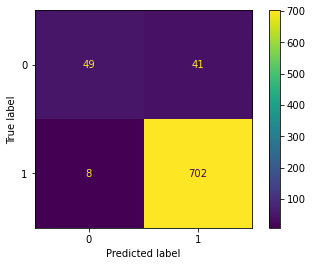

array([[ 49,  41],
       [  8, 702]])

In [104]:
conf_mat = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(conf_mat).plot()
plt.show()

display(conf_mat)

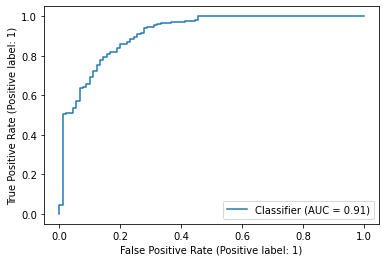

In [105]:
RocCurveDisplay.from_predictions(y, clf.score_samples(X.to_numpy()))

plt.show()

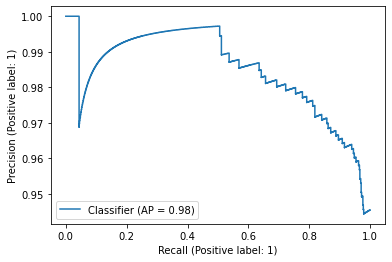

In [106]:
PrecisionRecallDisplay.from_predictions(y, clf.score_samples(X.to_numpy()))

plt.show()

In [107]:
cv_results = pd.DataFrame(res.cv_results_)

cv_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_B,param_client_fraction,param_max_rounds,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
8,126.467154,5.089406,3.111033,0.096615,1,1,5,"{'B': 1, 'client_fraction': 1, 'max_rounds': 5}",0.999863,0.999863,0.999863,0.000000,1
21,6.906253,0.128348,1.603019,0.009350,10,0.5,1,"{'B': 10, 'client_fraction': 0.5, 'max_rounds'...",0.999566,0.999307,0.999436,0.000129,2
3,8.842615,0.748768,1.848637,0.080700,1,0.5,1,"{'B': 1, 'client_fraction': 0.5, 'max_rounds': 1}",0.999574,0.999243,0.999409,0.000165,3
2,4.521712,2.655333,0.586945,0.325439,1,0.1,5,"{'B': 1, 'client_fraction': 0.1, 'max_rounds': 5}",0.998332,0.999046,0.998689,0.000357,4
14,26.167043,0.595105,1.517937,0.165674,5,0.5,5,"{'B': 5, 'client_fraction': 0.5, 'max_rounds': 5}",0.997499,0.999658,0.998578,0.001080,5
1,2.737081,0.537276,0.553792,0.069755,1,0.1,3,"{'B': 1, 'client_fraction': 0.1, 'max_rounds': 3}",0.997744,0.999305,0.998525,0.000781,6
11,6.644420,2.826296,0.739008,0.195713,5,0.1,5,"{'B': 5, 'client_fraction': 0.1, 'max_rounds': 5}",0.996397,0.999028,0.997712,0.001316,7
6,17.334013,3.641952,2.556843,0.325362,1,1,1,"{'B': 1, 'client_fraction': 1, 'max_rounds': 1}",0.995829,0.998740,0.997285,0.001456,8
15,15.784425,1.142179,2.451856,0.070674,5,1,1,"{'B': 5, 'client_fraction': 1, 'max_rounds': 1}",0.997226,0.997143,0.997185,0.000042,9
13,10.742437,4.666708,0.843172,0.397261,5,0.5,3,"{'B': 5, 'client_fraction': 0.5, 'max_rounds': 3}",0.994527,0.999356,0.996942,0.002414,10


In [108]:
print(np.average(cv_results['mean_test_score']))
print(np.std(cv_results['mean_test_score']))

0.9908624066181749
0.008175254880076359


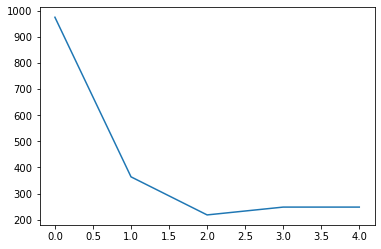

In [109]:
plt.plot(clf.sv_count)
plt.show()

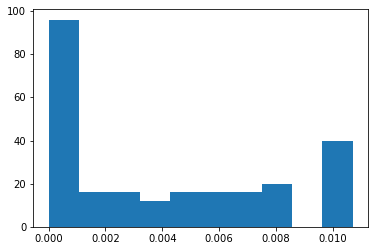

In [110]:
plt.hist(clf.clf.betas_)
plt.show()

In [111]:
display(pd.DataFrame(cv_results.groupby(['param_B'])['mean_test_score'].mean()))
display(pd.DataFrame(cv_results.groupby(['param_B'])['mean_test_score'].std()))
display(pd.DataFrame(cv_results.groupby(['param_client_fraction'])['mean_test_score'].mean()))
display(pd.DataFrame(cv_results.groupby(['param_client_fraction'])['mean_test_score'].std()))
display(pd.DataFrame(cv_results.groupby(['param_max_rounds'])['mean_test_score'].mean()))
display(pd.DataFrame(cv_results.groupby(['param_max_rounds'])['mean_test_score'].std()))

,mean_test_score
param_B,
1,0.993571
5,0.994418
10,0.984598


,mean_test_score
param_B,
1,0.008177
5,0.004750
10,0.008338


,mean_test_score
param_client_fraction,
0.1,0.992293
0.5,0.991251
1.0,0.989043


,mean_test_score
param_client_fraction,
0.1,0.008108
0.5,0.007724
1.0,0.009694


,mean_test_score
param_max_rounds,
1,0.992164
3,0.990266
5,0.990157


,mean_test_score
param_max_rounds,
1,0.007635
3,0.007922
5,0.010082


#### Non IID

In [112]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=total_clients)
client_assignment = list(kmeans.fit_predict(X))

In [113]:
from collections import Counter
Counter(client_assignment)

Counter({5: 121,
         6: 123,
         0: 97,
         1: 50,
         4: 105,
         2: 139,
         9: 38,
         3: 53,
         7: 46,
         8: 28})

In [114]:
parameters = {
'client_fraction': [.1, .5,  1],
'max_rounds': [1, 3, 5],
'B': [1, 5, 10]
}


test_fold = [0 if v < len(X) else 1 for v in range(len(X) * 2)]

search = GridSearchCV(FederatedBSVClassifier(normal_class_label=1, outlier_class_label=-1, total_clients=total_clients), parameters, cv=PredefinedSplit(test_fold=test_fold), refit=True, scoring='average_precision', error_score='raise', verbose=VERBOSE)
res = search.fit(pd.concat([X,X]).to_numpy(), np.array(y+y), client_assignment=client_assignment+client_assignment)

clf = res.best_estimator_

print(res.best_index_)
print(res.best_score_)
print(res.best_params_)


y_pred = clf.predict(X.to_numpy())

Round 0 of 1
Selected clients [6]
Round 0 of 1
Selected clients [2]
Round 0 of 3
Selected clients [1]
Round 1 of 3
Selected clients [4]
Round 2 of 3
Selected clients [4]
Round 0 of 3
Selected clients [0]
Round 1 of 3
Selected clients [9]
Round 2 of 3
Selected clients [2]
Round 0 of 5
Selected clients [8]
Client 8 does not have normal class datapoints among the 28 points
No datapoints after combining global model and client update. Is everything okay?
Round 1 of 5
Selected clients [5]
Round 2 of 5
Selected clients [5]
Round 3 of 5
Selected clients [3]
Round 4 of 5
Selected clients [6]
Round 0 of 5
Selected clients [6]
Round 1 of 5
Selected clients [8]
There is no client 8 update. No betas far from zero among all the 0 points
Round 2 of 5
Selected clients [5]
Round 3 of 5
Selected clients [4]
Round 4 of 5
Selected clients [2]
Round 0 of 1
Selected clients [5 1 4 0 3]
Round 0 of 1
Selected clients [5 0 7 8 9]
Client 8 does not have normal class datapoints among the 28 points
Round 0 of 3


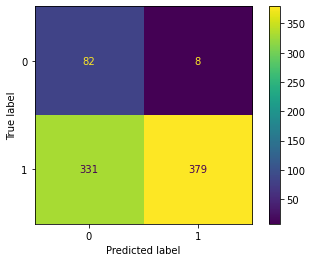

array([[ 82,   8],
       [331, 379]])

In [115]:
conf_mat = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(conf_mat).plot()
plt.show()

display(conf_mat)

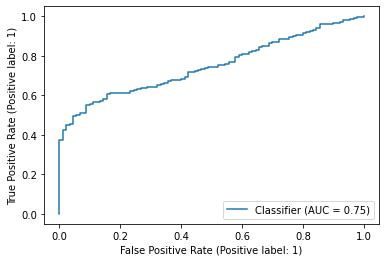

In [116]:
RocCurveDisplay.from_predictions(y, clf.score_samples(X.to_numpy()))

plt.show()

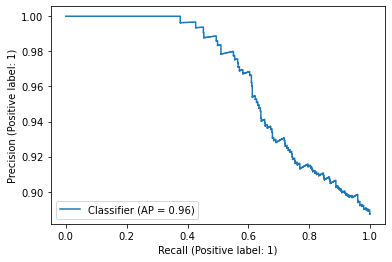

In [117]:
PrecisionRecallDisplay.from_predictions(y, clf.score_samples(X.to_numpy()))

plt.show()

In [118]:
cv_results = pd.DataFrame(res.cv_results_)

cv_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_B,param_client_fraction,param_max_rounds,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
14,15.749995,1.020465,0.993618,0.152444,5,0.5,5,"{'B': 5, 'client_fraction': 0.5, 'max_rounds': 5}",0.999843,0.997330,0.998587,0.001257,1
5,11.181002,0.384912,0.921538,0.060221,1,0.5,5,"{'B': 1, 'client_fraction': 0.5, 'max_rounds': 5}",0.998992,0.997833,0.998413,0.000580,2
16,10.851676,1.308394,0.735348,0.057368,5,1,3,"{'B': 5, 'client_fraction': 1, 'max_rounds': 3}",0.996891,0.997182,0.997037,0.000145,3
23,5.966544,1.168546,0.459085,0.193797,10,0.5,5,"{'B': 10, 'client_fraction': 0.5, 'max_rounds'...",0.989430,0.997720,0.993575,0.004145,4
25,6.900770,0.649934,0.484749,0.033752,10,1,3,"{'B': 10, 'client_fraction': 1, 'max_rounds': 3}",0.993791,0.984121,0.988956,0.004835,5
26,20.906766,1.455698,1.102646,0.211358,10,1,5,"{'B': 10, 'client_fraction': 1, 'max_rounds': 5}",0.972510,0.999617,0.986064,0.013554,6
17,21.085350,10.125584,0.893722,0.609675,5,1,5,"{'B': 5, 'client_fraction': 1, 'max_rounds': 5}",0.970372,0.999444,0.984908,0.014536,7
8,16.613472,1.312365,0.662569,0.418990,1,1,5,"{'B': 1, 'client_fraction': 1, 'max_rounds': 5}",0.999587,0.968713,0.984150,0.015437,8
2,2.468742,0.433658,0.357626,0.043231,1,0.1,5,"{'B': 1, 'client_fraction': 0.1, 'max_rounds': 5}",0.982168,0.984458,0.983313,0.001145,9
4,4.030722,0.192274,0.280435,0.066014,1,0.5,3,"{'B': 1, 'client_fraction': 0.5, 'max_rounds': 3}",0.989142,0.977091,0.983116,0.006026,10


In [119]:
print(np.average(cv_results['mean_test_score']))
print(np.std(cv_results['mean_test_score']))

0.969524333657698
0.02413349110167171


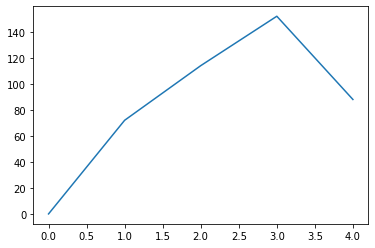

In [120]:
plt.plot(clf.sv_count)
plt.show()

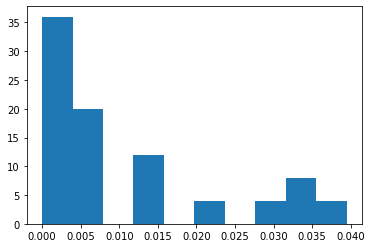

In [121]:
plt.hist(clf.clf.betas_)
plt.show()

In [122]:
display(pd.DataFrame(cv_results.groupby(['param_B'])['mean_test_score'].mean()))
display(pd.DataFrame(cv_results.groupby(['param_B'])['mean_test_score'].std()))
display(pd.DataFrame(cv_results.groupby(['param_client_fraction'])['mean_test_score'].mean()))
display(pd.DataFrame(cv_results.groupby(['param_client_fraction'])['mean_test_score'].std()))
display(pd.DataFrame(cv_results.groupby(['param_max_rounds'])['mean_test_score'].mean()))
display(pd.DataFrame(cv_results.groupby(['param_max_rounds'])['mean_test_score'].std()))

,mean_test_score
param_B,
1,0.973354
5,0.969884
10,0.965335


,mean_test_score
param_B,
1,0.021616
5,0.027059
10,0.027015


,mean_test_score
param_client_fraction,
0.1,0.958891
0.5,0.981910
1.0,0.967772


,mean_test_score
param_client_fraction,
0.1,0.024257
0.5,0.013641
1.0,0.029799


,mean_test_score
param_max_rounds,
1,0.948652
3,0.974173
5,0.985748


,mean_test_score
param_max_rounds,
1,0.024535
3,0.021182
5,0.010224
